In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
from scipy.optimize import minimize

In [197]:
class Horn:
    def __init__(self,phi=-30):
        self.set_phi(phi)
        
    def set_phi(self,phi_deg):
        phi_rad = phi_deg/180.*np.pi
        dh = 69.0
        dv = 69.1
        p1 = [-dh/2,0,0]
        p2 = [+dh/2,0,0]
        p3 = [+dh/2, dv*np.sin(phi_rad),-dv*np.cos(phi_rad)]
        p4 = [-dh/2, dv*np.sin(phi_rad),-dv*np.cos(phi_rad)]
        self.points = [np.array(p) for p in [p1,p2,p3,p4]]
    
class Dish:
    def __init__(self, x0, y0, z0, alpha, beta, f, dphi, r0, r1):
        self.set_params(x0, y0, z0, alpha, beta, f, dphi, r0, r1)
    
    def set_params(self, x0, y0, z0, alpha, beta, f, dphi, r0, r1):
        ofs = np.array([x0,y0,z0])
        f = 290.0
        ## petal from center, upring
        points_pet = [ (4,4), (5,3), (5,2), (5,1), (0,1), (-5,1), (-5,2), (-5,3), (-4,4)]
        dphi_rad = dphi/180*np.pi
        def get_point ( petal, upright, f):
            r = r0+(upright-1)*r1
            x = r*np.sin(dphi_rad*petal)
            y = r*np.cos(dphi_rad*petal)
            z = r*r/(4*np.abs(f))
            #print (r,x,y,z,dphi_rad, petal, upright)
            #stop()
            return np.array([x,y,z])
        
        points_xyz = [get_point(petal, upright,f) for petal,upright in points_pet]
        #print (points_xyz)
        #stop()
        ## now rotate them by alpha,beta and offset
        R = Rotation.from_euler('zy',[alpha,beta],degrees=True).as_matrix()   
        points_xyz = [np.dot(R,p)+ofs for p in points_xyz]
        self.points_xyz = points_xyz
    
def predict_measurements(vec):
    H = Horn(vec[0])
    pH = H.points
    D = Dish(*vec[1:])
    pD = D.points_xyz
    #print (pD)
    def dist(p1,p2):
        return np.sqrt(np.sum((p1-p2)**2))
    pred = np.array([[dist(p1,p2) for p1 in pH] for p2 in pD])
    return pred


In [198]:
measurements = np.array([
    [376.6, 337.0, 353.2, 390.8],
    [331.3, 291.8, 284.1, 324.1],
    [296.7, 269.2, 240.1, 269.5],
    [282.3, 271.1, 222.5, 235.6],    
    [272.5, 272.7, 228.3, 227.9],
    [270.0, 282.0, 236.5, 221.7],
    [266.7, 293.8, 269.4, 238.3],
    [288.3, 327.1, 323.1, 283.3],
    [333.7, 372.1, 389.4, 353.0]
])



In [282]:
# phi, x0,y0,z0,alpha,beta,f,dphi
start = np.array([-40, 0, -60, -270, 0, 0, 290., 8., 70., 100.])
sigma = 0.3 ## sigma err in cm
predict_measurements(start)

array([[375.05267932, 337.0561298 , 353.32073206, 389.73480386],
       [328.26636847, 289.49705065, 282.30470812, 321.94132162],
       [292.69453502, 265.68833905, 235.91740086, 265.96393995],
       [277.48324218, 266.05943205, 216.46932237, 230.36556999],
       [268.19220507, 268.19220507, 222.38079332, 222.38079332],
       [266.05943205, 277.48324218, 230.36556999, 216.46932237],
       [265.68833905, 292.69453502, 265.96393995, 235.91740086],
       [289.49705065, 328.26636847, 321.94132162, 282.30470812],
       [337.0561298 , 375.05267932, 389.73480386, 353.32073206]])

In [283]:

def chi2 (vec):
    pred = predict_measurements(vec)
    chi2 = ((pred-measurements)**2/sigma**2).sum()
    return chi2




In [284]:
fit = minimize(chi2,start,tol=1e-2)
fit.fun

32.558632509951735

In [285]:
predict_measurements(fit.x)

array([[376.37012604, 336.65255433, 353.14481259, 391.19149799],
       [331.13580823, 291.63822311, 284.12689557, 324.53992528],
       [296.45720836, 269.62906865, 239.96182695, 269.75677956],
       [282.23700954, 271.71508659, 222.92366704, 235.63446819],
       [272.09517305, 272.75812235, 228.10298634, 227.30983759],
       [269.88270163, 281.94406657, 236.11531146, 221.57313978],
       [266.77624764, 294.24451896, 269.11462328, 238.77271584],
       [288.16203818, 327.33696604, 323.03965382, 283.27105191],
       [333.95596089, 371.95354866, 389.17562839, 353.03655786]])

Text(0, 0.5, 'residuals [cm]')

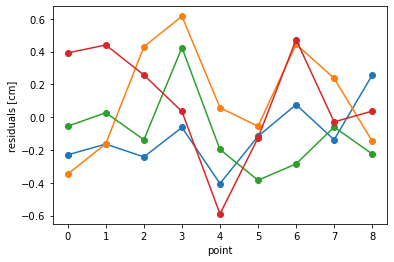

In [286]:
plt.plot(predict_measurements(fit.x)-measurements,'-o')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [287]:
vals = fit.x
errs=np.sqrt((fit.hess_inv.diagonal())*2)
names = 'phi x0 y0 z0 alpha beta f theta r0 r1'.split()
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

phi = -42.82 +/- 0.18
x0 = -4.28 +/- 0.52
y0 = -66.86 +/- 0.88
z0 = -274.34 +/- 0.15
alpha = -1.30 +/- 0.16
beta = 1.25 +/- 0.11
f = 290.00 +/- 1.41
theta = 8.12 +/- 0.05
r0 = 69.52 +/- 1.16
r1 = 100.86 +/- 0.20


In [288]:
# E dish
E_measurements = np.array([
    [388.2, 348.8, 364.6, 401.6], 
    [341.5, 302.9, 296.0, 335.9], 
    [306.4, 278.4, 250.2, 280.9],
    [289.9, 276.8, 229.4, 245.1],
    [280.4, 277.8, 233.4, 235.7],
    [276.9, 286.0, 241.3, 229.9],
    [275.1, 299.1, 274.0, 247.1],
    [296.9, 332.4, 327.4, 291.3],
    [346.6, 381.9, 396.3, 362.7]
])

In [289]:
def E_chi2 (vec):
    pred = predict_measurements(vec)
    chi2 = ((pred-E_measurements)**2/sigma**2).sum()
    return chi2

In [290]:
E_fit = minimize(E_chi2,start,tol=1e-2)
E_fit.fun

205.32348957746424

In [291]:
predict_measurements(E_fit.x)

array([[388.00649436, 349.25369898, 365.70394407, 402.87748525],
       [341.62888351, 302.33282504, 295.7755429 , 335.83973668],
       [306.05980799, 278.11768388, 249.62193501, 280.41802799],
       [289.94506433, 277.02291628, 228.96903895, 244.44480969],
       [280.23095043, 278.31062988, 233.80139049, 236.08402969],
       [276.96211286, 286.31397619, 240.33925401, 229.11847595],
       [275.7178077 , 299.83745052, 274.06044764, 247.44078426],
       [297.93594823, 333.58243594, 328.24239916, 291.94461852],
       [345.06307609, 379.95372797, 395.68033985, 362.30735905]])

Text(0, 0.5, 'residuals [cm]')

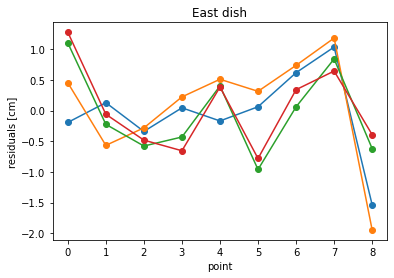

In [292]:
plt.plot(predict_measurements(E_fit.x)-E_measurements,'-o')
plt.title('East dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [293]:
vals = E_fit.x
errs=np.sqrt((E_fit.hess_inv.diagonal())*2)
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

phi = -40.99 +/- 0.16
x0 = 6.40 +/- 0.58
y0 = -58.07 +/- 0.79
z0 = -281.18 +/- 0.14
alpha = -1.11 +/- 0.16
beta = -0.35 +/- 0.12
f = 290.00 +/- 1.41
theta = 7.82 +/- 0.05
r0 = 72.33 +/- 1.01
r1 = 101.14 +/- 0.19


In [294]:
# S dish
S_measurements = np.array([
    [389.2, 346.8, 365.9, 401.1],
    [337.5, 298.6, 295.5, 334.2],
    [302.0, 274.4, 249.9, 279.4],
    [285.3, 273.8, 229.6, 243.6],
    [276.0, 275.9, 235.4, 235.8],
    [274.2, 285.4, 243.0, 229.7],
    [275.1, 299.9, 278.9, 250.4],
    [298.7, 336.8, 334.0, 296.6],
    [347.7, 384.2, 401.3, 367.9]
])

In [295]:
def S_chi2 (vec):
    pred = predict_measurements(vec)
    chi2 = ((pred-S_measurements)**2/sigma**2).sum()
    return chi2

In [296]:
S_fit = minimize(S_chi2, start, tol=1e-2)
S_fit.fun

243.70688364064378

In [297]:
predict_measurements(S_fit.x)

array([[386.1097742 , 346.82412951, 365.59456924, 403.05479774],
       [338.60184767, 299.24232561, 295.08361185, 334.93220178],
       [302.24878814, 275.04295838, 249.45670844, 279.16724443],
       [285.36279864, 274.08517602, 229.12481944, 242.50242476],
       [276.5823509 , 276.28829985, 235.47802249, 235.82296595],
       [273.91299462, 284.86681383, 242.47083218, 229.5023561 ],
       [274.94469354, 300.79911028, 278.7803296 , 250.66501937],
       [299.22452878, 336.42607376, 334.30534244, 296.83813349],
       [347.31673239, 383.48790206, 402.02478723, 367.6817525 ]])

Text(0, 0.5, 'residuals [cm]')

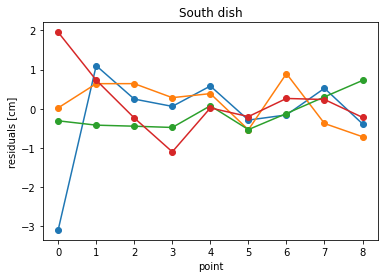

In [298]:
plt.plot(predict_measurements(S_fit.x)-S_measurements,'-o')
plt.title('South dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [299]:
vals = S_fit.x
errs=np.sqrt((S_fit.hess_inv.diagonal())*2)
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

phi = -44.01 +/- 0.18
x0 = -0.87 +/- 0.53
y0 = -52.81 +/- 0.91
z0 = -277.90 +/- 0.15
alpha = -1.70 +/- 0.15
beta = 0.07 +/- 0.11
f = 290.00 +/- 1.41
theta = 8.15 +/- 0.05
r0 = 69.04 +/- 1.16
r1 = 100.87 +/- 0.20


In [300]:
# W dish
W_measurements = np.array([
    [378.1, 352.3, 371.9, 405.2],
    [339.8, 301.7, 299.1, 336.2],
    [299.8, 273.5, 249.9, 278.1],
    [283.1, 270.8, 226.2, 241.0], # * Panel Damage
    [269.5, 269.3, 228.7, 229.9], # ** major panel-stanction damage
    [269.9, 280.4, 237.3, 223.8],
    [271.2, 299.2, 274.7, 245.3],
    [298.0, 336.3, 332.4, 293.7],
    [348.4, 386.1, 401.4, 366.9]
])

In [301]:
def W_chi2 (vec):
    pred = predict_measurements(vec)
    chi2 = ((pred-W_measurements)**2/sigma**2).sum()
    return chi2

In [302]:
W_fit = minimize(W_chi2, start, tol=1e-2)
W_fit.fun

975.243752534142

In [303]:
predict_measurements(W_fit.x)

array([[384.02039298, 351.65080389, 372.7898254 , 403.46701013],
       [336.00072663, 300.72269554, 300.31299326, 335.63409035],
       [299.52638807, 272.95394533, 250.01020978, 278.77823781],
       [282.86778159, 268.47909573, 223.83789094, 240.90777995],
       [272.01689307, 271.34179559, 229.87305435, 230.66954978],
       [268.95360159, 281.50957044, 237.81781663, 222.81318512],
       [271.6372009 , 298.95135538, 275.48969551, 245.57978004],
       [297.85240283, 336.16013957, 332.43482988, 293.64150006],
       [347.69377147, 385.31564654, 401.64018472, 365.70158495]])

Text(0, 0.5, 'residuals [cm]')

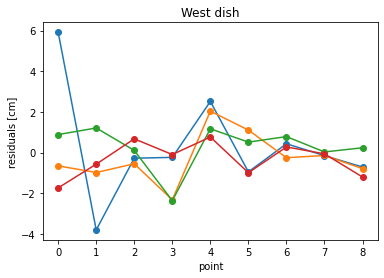

In [304]:
plt.plot(predict_measurements(W_fit.x)-W_measurements,'-o')
plt.title('West dish')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [305]:
vals = W_fit.x
errs=np.sqrt((W_fit.hess_inv.diagonal())*2)
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

phi = -39.96 +/- 0.18
x0 = 8.21 +/- 0.56
y0 = -60.10 +/- 1.04
z0 = -274.81 +/- 0.19
alpha = 3.42 +/- 0.15
beta = -0.72 +/- 0.12
f = 290.00 +/- 1.41
theta = 7.20 +/- 0.05
r0 = 91.70 +/- 1.40
r1 = 98.55 +/- 0.20
